# Face Recognition with the Labeled Faces in the Wild dataset
#### (By Siân Nadin)


Using a support vector machine algorithm for face image classification. In order to complete this task we must train a classifier after reducing dimensionality using eigenfaces. I have chosen to use support vector machine classification for this task as it is a robust general classifier and is effective in high dimensional spaces. Since the number of features is much greater than the number of samples I will be training an SVM with the Radial Basis Function (RBF) kernel and tuning the C and gamma parameters in order to avoid overfitting. 


The steps taken are as follows:

1. Split the data into a training and test set
2. Perform PCA to find the eigenfaces from the training dataset. Choosing the right number of components at this stage is important as performance starts to drop off with too many PCs which can be seen by a drop in the F1 score.
3. Train an SVM using using cross-validation. There are two parameters to tune: (i) C which controls how soft margins can be and helps prevent overfitting (ii) gamma which controls the shapes of the kernels used allowing the classifier to work on non-linearly separable data.
4. Use the best performing models from the cross-validation grid search to predict the names of the faces from the test data.
5. Assess the performance of the model.

In [1]:
%pylab inline

import pylab as pl
import numpy as np

Populating the interactive namespace from numpy and matplotlib


## Download the LFW dataset

In [2]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

## 1. Split the dataset into training and testing sets

In [3]:
from sklearn.cross_validation import train_test_split

X = lfw_people.data
Y = lfw_people.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

n_samples, h, w = lfw_people.images.shape
names = lfw_people.target_names
n_classes = names.shape[0]
n_samples, n_features = X.shape

print "Number of samples: {}".format(n_samples)
print "Number of features: {}".format(n_features)
print "Number of classes: {}".format(n_classes)
print "Names of people in the dataset:", names

Number of samples: 1288
Number of features: 1850
Number of classes: 7
Names of people in the dataset: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


In [4]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())

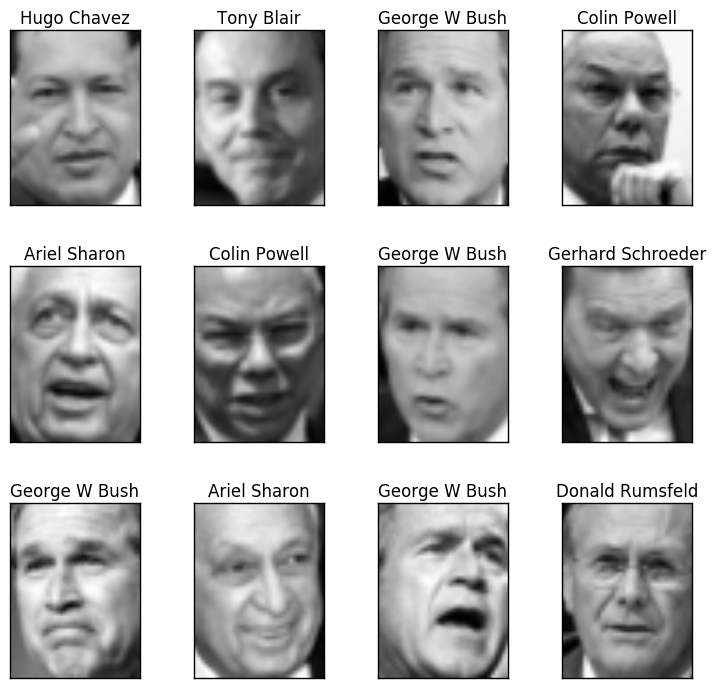

In [5]:
plot_gallery(X, names[Y], h, w)

## 2. Feature extraction with PCA

In [6]:
from sklearn.decomposition import RandomizedPCA

n_components = 100

print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

Extracting the top 100 eigenfaces from 901 faces


We can plot the gallery of the most significant eigenfaces:

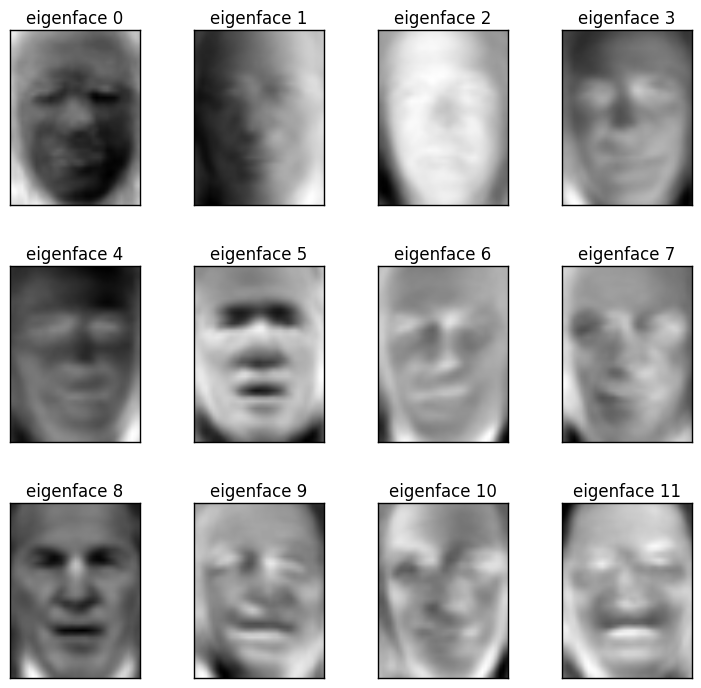

In [7]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

Project the input data on the eigenfaces orthonormal basis:

In [8]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

## 3. Train projected data using Support Vector mechanics 

In [9]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score

# perform an automated parameter search to find good values for Gamma and C
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)

In [10]:
clf = clf.fit(X_train_pca, Y_train)

print("Best estimator found by randomized hyper parameter search:")
print(clf.best_params_)


Best estimator found by randomized hyper parameter search:
{'C': 1000.0, 'gamma': 0.005}


## 4. Predict the names of the faces from the test data

In [11]:
# Predicting people names in the test set
Y_pred = clf.predict(X_test_pca)

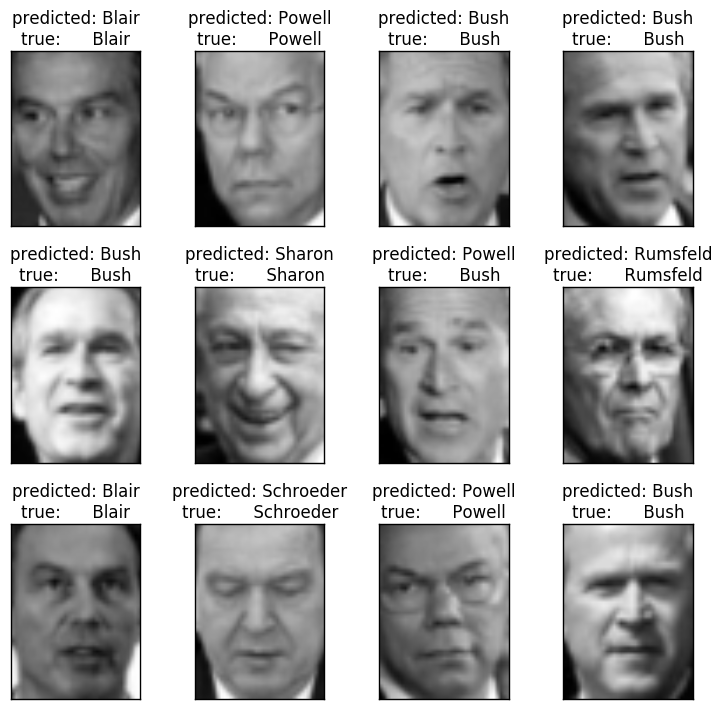

In [12]:
# plot the result of the prediction on a portion of the test set

def title(Y_pred, Y_test, target_names, i):
    pred_name = target_names[Y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[Y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(Y_pred, Y_test, names, i)
                         for i in range(Y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

## 5. Assess performance

In [13]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

print('F1 score: {:.4f}'.format(f1_score(Y_test,Y_pred,average='macro')))
print('Accuracy: {:.2f}%'.format(accuracy_score(Y_test,Y_pred)*100))

F1 score: 0.8045
Accuracy: 86.30%


* **Accuracy** is simply a ratio of correctly predicted observation to the total observations. It is a great measure but only when you have symmetric datasets where values of false positive and false negatives are almost same. An accuracy 0f 83.46% would lead you to believe that the algorithm is performing quite well and we can be quite confident in its predictions.

* **F1 Score** is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. An F1 score of 0.8 indicates a relatively high value of precision and recall.

Taking the accuracy and F1 score into account we can be quite confident that the algorithm will correctly identify people.

In [14]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, Y_pred, target_names=names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.92      0.60      0.73        20
     Colin Powell       0.81      0.91      0.86        69
  Donald Rumsfeld       0.83      0.85      0.84        34
    George W Bush       0.89      0.95      0.92       173
Gerhard Schroeder       0.76      0.59      0.67        22
      Hugo Chavez       0.89      0.70      0.78        23
       Tony Blair       0.88      0.80      0.84        46

      avg / total       0.86      0.86      0.86       387



Below is the matrix we get after running PCA and then using that in an SVM algorithm. The rows are the true values and the columns represent the predicted values. All of the off diagonal elements relate to miss classifications. For example, the algorithm seems to be able to correctly predict George Bush a lot of the time but often incorrectly predicts other people as George Bush as well.  

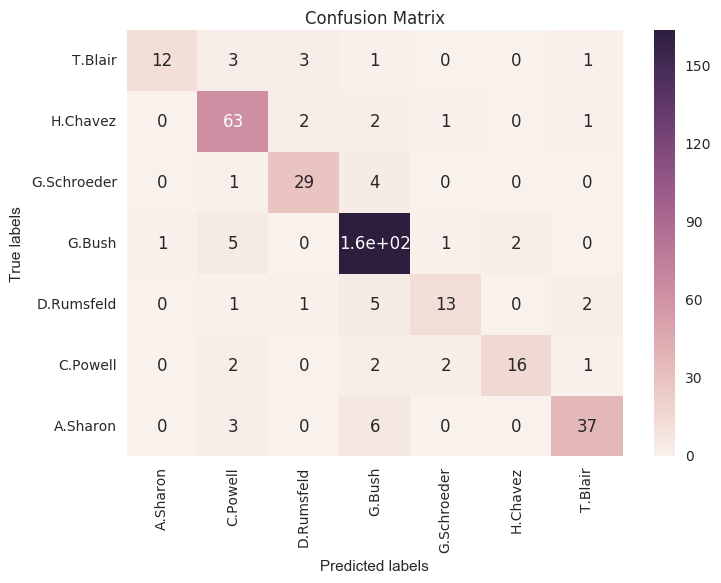

In [16]:
from sklearn.metrics import confusion_matrix

# Print confusion matrix
cm = confusion_matrix(Y_test, Y_pred, labels=range(n_classes))

import seaborn as sns
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax=ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['A.Sharon', 'C.Powell' ,'D.Rumsfeld' ,'G.Bush',
 'G.Schroeder', 'H.Chavez', 'T.Blair'], rotation =90); 
ax.yaxis.set_ticklabels(['A.Sharon', 'C.Powell' ,'D.Rumsfeld' ,'G.Bush',
 'G.Schroeder', 'H.Chavez', 'T.Blair'], rotation =0);